In [21]:
import torch.optim as optim
import lightweight_unet
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import cv2
import os

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from torchinfo import summary

BASE_DIR = "/home/adrien/Documents/P-SAT/Galaxy_Morphology_Classification"

In [2]:
# Data extraction

file_path_T = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_attributes.txt"
file_path_label = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_HyperLeda.txt"
file_path_angle = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_PGC.txt"

df_T = pd.read_csv(file_path_T, sep='\s+', comment='#', header=None,
                       names=[
                           'PGC_name', 'T', 'T_inf', 'T_sup', 
                           'Bulge_to_Total', 'Bulge_to_Total_inf', 'Bulge_to_Total_sup',
                           'Arm_Strength', 'Arm_Strength_inf', 'Arm_Strength_sup', 
                           'Arm_Curvature', 'Arm_Curvature_inf', 'Arm_Curvature_sup',
                           'Arm_Rotation', 'Arm_Rotation_inf', 'Arm_Rotation_sup', 
                           'Bar_Length', 'Bar_Length_inf', 'Bar_Length_sup',
                           'Inner_Ring', 'Inner_Ring_inf', 'Inner_Ring_sup',
                           'Outer_Ring', 'Outer_Ring_inf', 'Outer_Ring_sup', 
                           'Pseudo_Ring', 'Pseudo_Ring_inf', 'Pseudo_Ring_sup',
                           'Perturbation', 'Perturbation_inf', 'Perturbation_sup',
                           'Visible_Dust', 'Visible_Dust_inf', 'Visible_Dust_sup',
                           'Dust_Dispersion', 'Dust_Dispersion_inf', 'Dust_Dispersion_sup',
                           'Flocculence', 'Flocculence_inf', 'Flocculence_sup',
                           'Hot_Spots', 'Hot_Spots_inf', 'Hot_Spots_sup', 
                           'Inclination', 'Inclination_inf', 'Inclination_sup',
                           'Contamination', 'Contamination_inf', 'Contamination_sup',
                           'Multiplicity', 'Multiplicity_inf', 'Multiplicity_sup'
                       ])

df_label = pd.read_csv(file_path_label, sep='\s+', comment='#', header=None,
                names=['PGC_name', 'PGC_no', 'vrad', 'e_vrad', 'vopt', 'e_vopt', 
                        'v', 'e_v', 'vvir', 'zvir', 'z_err', 'type', 'objname', 'hl_names'])

df_pgc = pd.read_csv(file_path_angle, sep='\s+', comment='#', header=None, 
                     names=['PGC_name', 'T_PGC', 'T_PGC_err', 'type_expanded', 'D25', 
                            'R25', 'PA', 'B_T_mag', 'e_B_T_mag', 'B_V_T', 'e_B_V_T', 
                            'cz', 'z'])

df_filtered = df_label[['PGC_name', 'type']]
df_label_T = pd.merge(df_filtered, df_T[['PGC_name', 'T', 'Inclination']], on='PGC_name', how='left')
data = pd.merge(df_label_T, df_pgc[['PGC_name', 'PA']], on='PGC_name', how='left')

data['normalized_T'] = data['T'] + 6

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PGC_name      4458 non-null   object 
 1   type          4458 non-null   object 
 2   T             4458 non-null   int64  
 3   Inclination   4458 non-null   float64
 4   PA            4458 non-null   int64  
 5   normalized_T  4458 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 209.1+ KB


Index : 0 | type : Sab | T : 1 | normalized_T : 7 | Inclination : 0.75 | angle : 54
Dimension de l'image : (255, 255, 3)


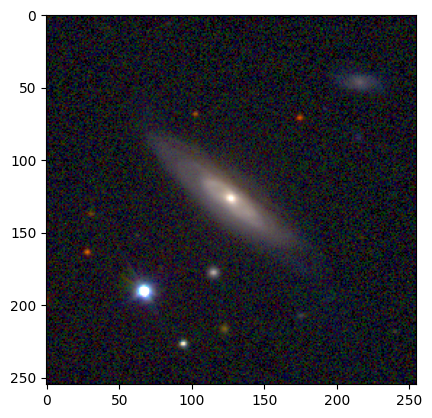

In [16]:
# Data vizualisation

index = 0

image = cv2.imread(f"{BASE_DIR}/data/efigi_png_gri-1.6/png/{data['PGC_name'][index]}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Index : {index} | type : {data['type'][index]} | T : {data['T'][index]} | normalized_T : {data['normalized_T'][index]} | Inclination : {data['Inclination'][index]} | angle : {data['PA'][index]}")
print(f"Dimension de l'image : {image.shape}")

plt.imshow(image)
plt.show()

Nombre de classes uniques dans T : 18


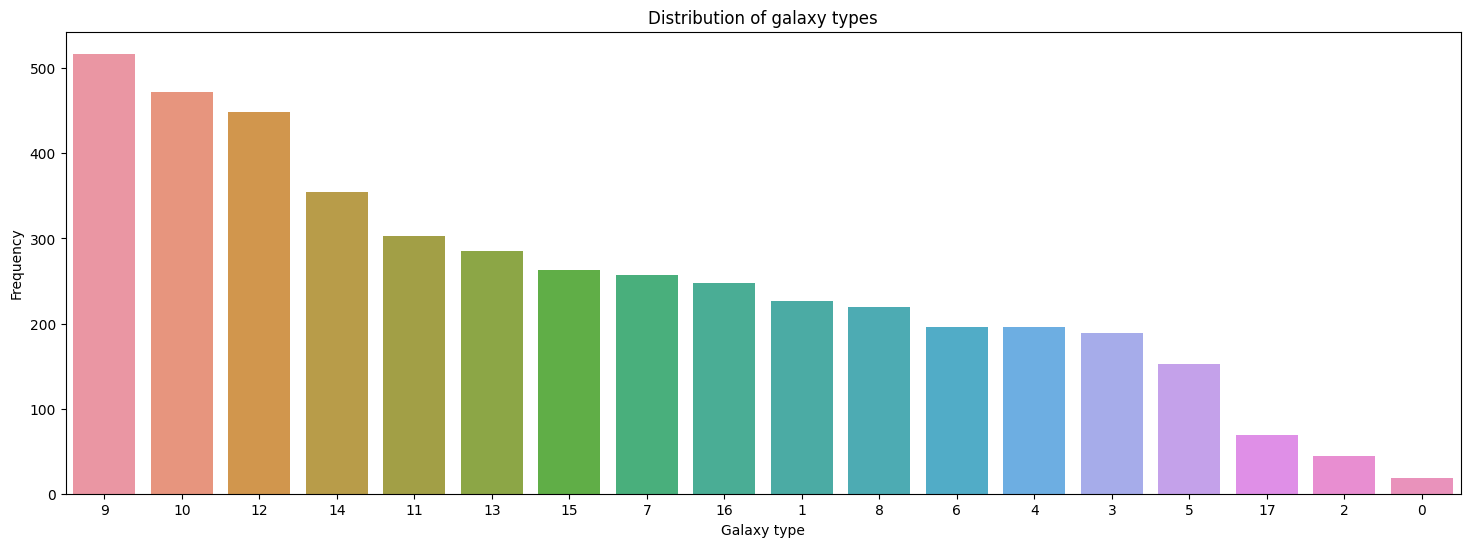

In [28]:
# Class vizualisation

print(f"Nombre de classes uniques dans T : {data['normalized_T'].nunique()}")

plt.figure(figsize=(18, 6))
sns.countplot(x='normalized_T', data=data, order=data['normalized_T'].value_counts().index)
plt.title('Distribution of galaxy types')
plt.xlabel('Galaxy type')
plt.ylabel('Frequency')
plt.show()

In [24]:
class GalaxyDataset(Dataset):
    def __init__(self, data_dir, labels_df, transform=None):
        self.data_dir = data_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        image_id = self.labels_df.iloc[idx]['PGC_name']
        label = int(self.labels_df.iloc[idx]['normalized_T'])

        image_path = os.path.join(self.data_dir, f"{image_id}.png")
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:
            image = cv2.resize(image, (64, 64))
            image = torch.from_numpy(image.transpose((2, 0, 1)))
            image = image.float() / 255.0  # Normalize to [0, 1]

        label = torch.tensor([label], dtype=torch.long).squeeze(0)

        return image, label

In [34]:
# Data preparation

data_dir = f"{BASE_DIR}/data/efigi_png_gri-1.6/png"

dataset = GalaxyDataset(data_dir, data, transform=None)

# Train : 75% | validation : 15% | test : 10%
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

sample_image, _ = dataset[0]
print(f"Shape of a single input image: {sample_image.shape}")

Training set size: 3343
Validation set size: 668
Test set size: 447
Shape of a single input image: torch.Size([3, 255, 255])


In [35]:
# Model initialization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lightweight_unet.LightweightUNet(input_channels=3, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(32, 3, 255, 255)) # batch size / channels / height / width

Layer (type:depth-idx)                   Output Shape              Param #
LightweightUNet                          [32, 18]                  --
├─Sequential: 1-1                        [32, 32, 127, 127]        --
│    └─Sequential: 2-1                   [32, 32, 255, 255]        --
│    │    └─Conv2d: 3-1                  [32, 32, 255, 255]        896
│    │    └─BatchNorm2d: 3-2             [32, 32, 255, 255]        64
│    │    └─ReLU: 3-3                    [32, 32, 255, 255]        --
│    │    └─Conv2d: 3-4                  [32, 32, 255, 255]        9,248
│    │    └─BatchNorm2d: 3-5             [32, 32, 255, 255]        64
│    │    └─ReLU: 3-6                    [32, 32, 255, 255]        --
│    └─MaxPool2d: 2-2                    [32, 32, 127, 127]        --
├─Sequential: 1-2                        [32, 64, 63, 63]          --
│    └─Sequential: 2-3                   [32, 64, 127, 127]        --
│    │    └─Conv2d: 3-7                  [32, 64, 127, 127]        18,496
│    │ 

In [8]:
# Training

epochs = 2
model = model.to(device)
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_light_unet.pth')
        print("Saved Best Model")

Epoch 1/2
Train Loss: 2.5258, Val Loss: 2.4688, Val Accuracy: 0.1737
Saved Best Model
Epoch 2/2
Train Loss: 2.1422, Val Loss: 2.2547, Val Accuracy: 0.1811
Saved Best Model


/tmp/ipykernel_9513/12186768.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_light_unet.pth'))



Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.19      0.93      0.32        40
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        25
           7       0.27      0.08      0.12        38
           8       0.00      0.00      0.00        30
           9       0.37      0.22      0.27        92
          10       0.21      0.14      0.17        70
          11       0.00      0.00      0.00        40
          12       0.21      0.32      0.26        71
          13       0.00      0.00      0.00        53
          14       0.06      0.08      0.07        51
          15       0.00      0.00      0.00        37
          16       0.15      0.88      0.25        32
  

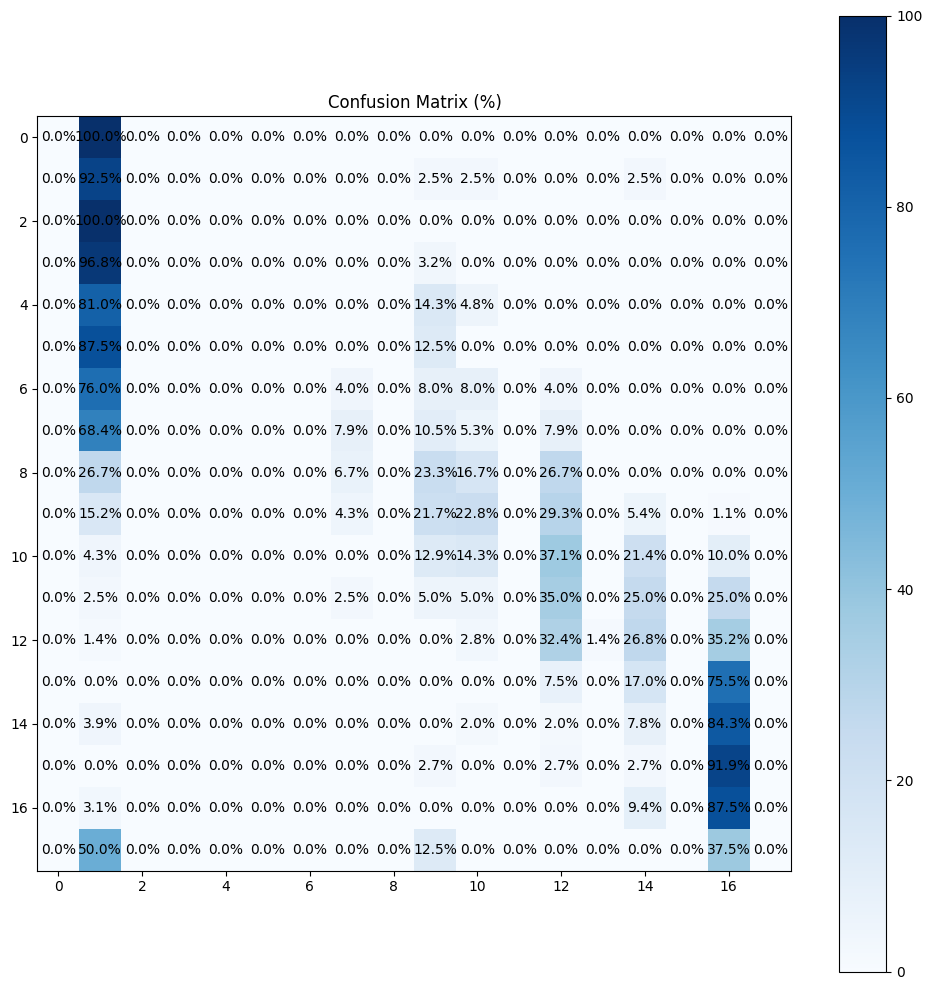

In [15]:
# Evaluation

model.load_state_dict(torch.load('best_light_unet.pth'))
model = model.to(device)
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

report = classification_report(all_labels, all_predictions, zero_division=0)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(all_labels, all_predictions)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 10))
plt.imshow(cm_pct, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm_pct[i, j]:.1f}%", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()